# MLP for TF Function

In [1]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

## Data

In [75]:
# Load data
freq_data = np.genfromtxt("TTF_Data_100.000_1.500_2.500.csv.csv")

# Load pickle
with open("TTF_data.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values.pt", "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data < 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape)

# Use only certain freq
idx = 0
freq = freq_data[:]
print(freq, idx)

(146, 256) (146,)
[0.1        0.10122847 0.10247203 0.10373087 0.10500518 0.10629513
 0.10760094 0.10892278 0.11026087 0.11161539 0.11298655 0.11437456
 0.11577962 0.11720194 0.11864173 0.12009921 0.12157459 0.1230681
 0.12457996 0.12611039 0.12765962 0.12922788 0.1308154  0.13242243
 0.1340492  0.13569596 0.13736294 0.13905041 0.1407586  0.14248778
 0.1442382  0.14601013 0.14780382 0.14961954 0.15145758 0.15331819
 0.15520166 0.15710826 0.15903829 0.16099203 0.16296977 0.16497181
 0.16699844 0.16904997 0.1711267  0.17322894 0.17535701 0.17751122
 0.17969189 0.18189935 0.18413393 0.18639596 0.18868578 0.19100373
 0.19335016 0.19572541 0.19812984 0.20056381 0.20302767 0.20552181
 0.20804659 0.21060238 0.21318957 0.21580854 0.21845968 0.2211434
 0.22386008 0.22661013 0.22939397 0.23221201 0.23506467 0.23795237
 0.24087555 0.24383463 0.24683007 0.2498623  0.25293179 0.25603898
 0.25918435 0.26236835 0.26559147 0.26885418 0.27215698 0.27550035
 0.27888479 0.28231081 0.28577891 0.28928963 0

In [5]:
# Separate the 10 values randomly for testing
test_indices = np.random.choice(len(TTF_data), 10, replace=False)
test_TTF_data = TTF_data[test_indices][:, :]
test_Vs_data = Vs_data[test_indices]

train_indices = np.delete(np.arange(len(TTF_data)), test_indices)
train_TTF_data = TTF_data[train_indices][:, :]
train_Vs_data = Vs_data[train_indices]

print("Training data size: " ,train_TTF_data.shape, train_Vs_data.shape)
print("Testing data size: ", test_TTF_data.shape, test_Vs_data.shape)

Training data size:  (136, 256) (136,)
Testing data size:  (10, 256) (10,)


In [7]:
# Crate Meshgrid
freq_values, Vs_values = np.meshgrid(freq, train_Vs_data)
print(Vs_values.shape, freq_values.shape, train_TTF_data.shape)

# Flatten the meshgrid
Vs_values = Vs_values.flatten()
freq_values = freq_values.flatten()
TTF_values = train_TTF_data.flatten()
print(Vs_values.shape, freq_values.shape, TTF_values.shape)

(136, 256) (136, 256) (136, 256)
(34816,) (34816,) (34816,)


In [8]:
class TTFDataset(Dataset):
    def __init__(self, TTF_data, Vs_array, freq_array):
        self.TTF_data = TTF_data
        self.Vs_array = Vs_array
        self.freq_array = freq_array

    def __len__(self):
        return len(self.TTF_data)

    def __getitem__(self, idx):

        # Input 
        Vs = self.Vs_array[idx] * np.ones(30)
        freq = self.freq_array[idx] * np.ones(1)
        input_data = np.concatenate((Vs, freq))
        input_data = torch.tensor(input_data, dtype=torch.float32)

        # Target
        TTF = self.TTF_data[idx] * np.ones(1)
        target = torch.tensor(TTF, dtype=torch.float32)

        return input_data, target

In [9]:
# Normalize the data
def normalize_data(data, mean, std):
    return (data - mean) / std

def denormalize_data(data, mean, std):
    return data * std + mean

# Normalize the data
mean_Vs = Vs_values.mean()
std_Vs = Vs_values.std()
mean_freq = freq_values.mean()
std_freq = freq_values.std()
mean_TTF = TTF_values.mean()
std_TTF = TTF_values.std()

Vs_values = normalize_data(Vs_values, mean_Vs, std_Vs)
freq_values = normalize_data(freq_values, mean_freq, std_freq)
TTF_values = normalize_data(TTF_values, mean_TTF, std_TTF)

# Create dataset
dataset = TTFDataset(TTF_values, Vs_values, freq_values)

In [12]:
# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

i_batch_size = 2000
train_loader = DataLoader(train_dataset, batch_size=i_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=i_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=i_batch_size, shuffle=True)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Train, validation and test sizes:  27852 3482 3482
Number of batches:  14 2 2


## Model

In [13]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

In [14]:
# Create TF model
class TF_model(nn.Module):
    def __init__(self, input_dim=31, output_dim=1):
        super(TF_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fmlp1 = MLP(input_dim-1, 30, 2, output_dim=1, activation=nn.ReLU)
        self.fmlp2 = MLP(2, 32, 2, output_dim=1, activation=nn.ReLU)

    def forward(self, x):
        x1 = x[:, :-1]
        x2 = x[:, -1].unsqueeze(1) 
        x1 = self.fmlp1(x1)
        x = torch.stack((x1, x2), dim=1).squeeze(2)
        x = self.fmlp2(x)
        return x


Preliminary check if the shapes are correct

In [15]:
model = MLP(31, 30, 2, output_dim=1, activation=nn.Sigmoid)
loss_fn = nn.MSELoss()
X,y = next(iter(train_loader))
print(X.shape, y.shape)
pred = model(X)
assert pred.shape == y.shape , f"Expected shape {y.shape} but got {pred.shape}"
print("Loss: ", loss_fn(pred, y))

torch.Size([2000, 31]) torch.Size([2000, 1])
Loss:  tensor(1.2688, grad_fn=<MseLossBackward0>)


## Training

Defining the Early Stopping to avoid redudant training if the loss is not decreasing.

In [16]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

### Training function

In [17]:
import torch
from tqdm import tqdm, trange
import torch.nn as nn
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", patience=50):
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model

### Testing function

In [18]:
# Define test function
def test(model, test_dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

## Start of Training

In [19]:
# Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
# Model
model = MLP(31, 30, 4, output_dim=1, activation=nn.ReLU, batch_norm=True)
#model = TF_model()

# Xavier Glore initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

# Loss function - RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = rmse

In [21]:
# Optimizer with momentum NAG
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.01, nesterov=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.6, 0.999), weight_decay=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05, alpha=0.9, eps=1e-08, weight_decay=0.01, momentum=0.9, centered=False)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)


# Scheduler with exponential decay
#scheduler = None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=250, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08)

In [22]:
# Train model
train_losses, val_losses, model = train(model, optimizer, scheduler, train_loader, val_loader, loss_fn, epochs=10000, device=device, patience=1000)

Training:   0%|          | 1/10000 [00:02<5:36:57,  2.02s/epoch]

Epoch 0, Train Loss: 1.0969489131655012, Val Loss: 1.0297819077968597, LR: 0.01


Training:   1%|          | 101/10000 [02:06<3:52:52,  1.41s/epoch, EarlyStopping counter: 11 out of 1000]

Epoch 100, Train Loss: 0.5188181506735938, Val Loss: 0.6544519066810608, LR: 0.01


Training:   2%|▏         | 201/10000 [04:05<3:05:50,  1.14s/epoch, EarlyStopping counter: 77 out of 1000]

Epoch 200, Train Loss: 0.4639450950281961, Val Loss: 0.6437089443206787, LR: 0.01


Training:   3%|▎         | 301/10000 [05:59<3:02:55,  1.13s/epoch, EarlyStopping counter: 49 out of 1000] 

Epoch 300, Train Loss: 0.43971188153539387, Val Loss: 0.5853807330131531, LR: 0.01


Training:   4%|▍         | 401/10000 [07:54<2:59:05,  1.12s/epoch, EarlyStopping counter: 149 out of 1000]

Epoch 400, Train Loss: 0.41873939761093687, Val Loss: 0.569778710603714, LR: 0.01


Training:   5%|▌         | 501/10000 [09:48<2:56:51,  1.12s/epoch, EarlyStopping counter: 249 out of 1000]

Epoch 500, Train Loss: 0.4563867002725601, Val Loss: 0.3745528310537338, LR: 0.01


Training:   6%|▌         | 601/10000 [12:23<5:04:49,  1.95s/epoch, EarlyStopping counter: 3 out of 1000]  

Epoch 600, Train Loss: 0.3116941377520561, Val Loss: 0.28260770440101624, LR: 0.005


Training:   7%|▋         | 701/10000 [15:31<5:28:34,  2.12s/epoch, EarlyStopping counter: 66 out of 1000]

Epoch 700, Train Loss: 0.29091249832085203, Val Loss: 0.3741118311882019, LR: 0.005


Training:   8%|▊         | 801/10000 [19:01<8:09:31,  3.19s/epoch, EarlyStopping counter: 166 out of 1000]

Epoch 800, Train Loss: 0.3056566821677344, Val Loss: 0.43568357825279236, LR: 0.005


Training:   9%|▉         | 901/10000 [21:04<2:26:55,  1.03epoch/s]                                        

Epoch 900, Train Loss: 0.2403150349855423, Val Loss: 0.1398017778992653, LR: 0.0025


Training:  10%|█         | 1001/10000 [22:43<2:44:54,  1.10s/epoch, EarlyStopping counter: 35 out of 1000]

Epoch 1000, Train Loss: 0.21504386674080575, Val Loss: 0.1569114476442337, LR: 0.0025


Training:  11%|█         | 1101/10000 [24:26<2:24:15,  1.03epoch/s, EarlyStopping counter: 65 out of 1000]

Epoch 1100, Train Loss: 0.22179233921425684, Val Loss: 0.329412043094635, LR: 0.0025


Training:  12%|█▏        | 1201/10000 [26:08<2:18:57,  1.06epoch/s, EarlyStopping counter: 165 out of 1000]

Epoch 1200, Train Loss: 0.2663091538207872, Val Loss: 0.17632324993610382, LR: 0.0025


Training:  13%|█▎        | 1301/10000 [27:49<2:06:50,  1.14epoch/s, EarlyStopping counter: 10 out of 1000] 

Epoch 1300, Train Loss: 0.1889694950410298, Val Loss: 0.22166331112384796, LR: 0.00125


Training:  14%|█▍        | 1401/10000 [29:21<1:52:45,  1.27epoch/s, EarlyStopping counter: 33 out of 1000]

Epoch 1400, Train Loss: 0.16892543275441443, Val Loss: 0.14892786741256714, LR: 0.00125


Training:  15%|█▌        | 1501/10000 [30:42<2:06:28,  1.12epoch/s, EarlyStopping counter: 133 out of 1000]

Epoch 1500, Train Loss: 0.18731480251465524, Val Loss: 0.1485329270362854, LR: 0.00125


Training:  16%|█▌        | 1601/10000 [32:21<2:09:44,  1.08epoch/s, EarlyStopping counter: 19 out of 1000] 

Epoch 1600, Train Loss: 0.1706616287784917, Val Loss: 0.2522539719939232, LR: 0.00125


Training:  17%|█▋        | 1701/10000 [34:01<2:05:33,  1.10epoch/s, EarlyStopping counter: 119 out of 1000]

Epoch 1700, Train Loss: 0.15671314458761895, Val Loss: 0.1962917447090149, LR: 0.00125


Training:  18%|█▊        | 1801/10000 [35:42<2:25:23,  1.06s/epoch, EarlyStopping counter: 74 out of 1000] 

Epoch 1800, Train Loss: 0.18289443584425108, Val Loss: 0.16781073808670044, LR: 0.00125


Training:  19%|█▉        | 1901/10000 [37:22<2:25:28,  1.08s/epoch, EarlyStopping counter: 10 out of 1000] 

Epoch 1900, Train Loss: 0.1540112170789923, Val Loss: 0.2516547664999962, LR: 0.00125


Training:  20%|██        | 2001/10000 [38:56<2:28:10,  1.11s/epoch, EarlyStopping counter: 110 out of 1000]

Epoch 2000, Train Loss: 0.188846976097141, Val Loss: 0.1094711497426033, LR: 0.00125


Training:  21%|██        | 2101/10000 [40:40<2:17:42,  1.05s/epoch, EarlyStopping counter: 25 out of 1000] 

Epoch 2100, Train Loss: 0.16714796211038316, Val Loss: 0.1619035080075264, LR: 0.00125


Training:  22%|██▏       | 2201/10000 [42:19<1:47:36,  1.21epoch/s, EarlyStopping counter: 125 out of 1000]

Epoch 2200, Train Loss: 0.17374544590711594, Val Loss: 0.1696036234498024, LR: 0.00125


Training:  23%|██▎       | 2301/10000 [44:02<2:13:03,  1.04s/epoch, EarlyStopping counter: 225 out of 1000]

Epoch 2300, Train Loss: 0.17624913901090622, Val Loss: 0.1203119121491909, LR: 0.00125


Training:  24%|██▍       | 2401/10000 [45:40<2:05:37,  1.01epoch/s, EarlyStopping counter: 52 out of 1000] 

Epoch 2400, Train Loss: 0.16035283197249686, Val Loss: 0.10849009454250336, LR: 0.000625


Training:  25%|██▌       | 2501/10000 [47:18<2:17:34,  1.10s/epoch, EarlyStopping counter: 152 out of 1000]

Epoch 2500, Train Loss: 0.14344603195786476, Val Loss: 0.09493542835116386, LR: 0.000625


Training:  26%|██▌       | 2601/10000 [49:00<2:02:36,  1.01epoch/s, EarlyStopping counter: 68 out of 1000] 

Epoch 2600, Train Loss: 0.13123089500835963, Val Loss: 0.13537749275565147, LR: 0.000625


Training:  27%|██▋       | 2701/10000 [50:35<2:05:45,  1.03s/epoch, EarlyStopping counter: 168 out of 1000]

Epoch 2700, Train Loss: 0.14941277408174106, Val Loss: 0.14474745839834213, LR: 0.000625


Training:  28%|██▊       | 2801/10000 [54:02<5:29:11,  2.74s/epoch, EarlyStopping counter: 268 out of 1000]

Epoch 2800, Train Loss: 0.11889169897351946, Val Loss: 0.1334344744682312, LR: 0.0003125


Training:  29%|██▉       | 2901/10000 [56:25<1:56:29,  1.02epoch/s, EarlyStopping counter: 55 out of 1000] 

Epoch 2900, Train Loss: 0.1331675574183464, Val Loss: 0.08811482414603233, LR: 0.0003125


Training:  30%|███       | 3001/10000 [58:56<2:13:51,  1.15s/epoch, EarlyStopping counter: 155 out of 1000]

Epoch 3000, Train Loss: 0.12590982179556573, Val Loss: 0.10191483050584793, LR: 0.0003125


Training:  31%|███       | 3101/10000 [1:00:47<1:37:06,  1.18epoch/s, EarlyStopping counter: 255 out of 1000]

Epoch 3100, Train Loss: 0.13247256779244967, Val Loss: 0.08683723211288452, LR: 0.00015625


Training:  32%|███▏      | 3201/10000 [1:02:10<1:36:05,  1.18epoch/s, EarlyStopping counter: 24 out of 1000] 

Epoch 3200, Train Loss: 0.11604975962213107, Val Loss: 0.08076704293489456, LR: 0.00015625


Training:  33%|███▎      | 3301/10000 [1:04:13<7:26:19,  4.00s/epoch, EarlyStopping counter: 23 out of 1000]

Epoch 3300, Train Loss: 0.12000228358166558, Val Loss: 0.08221123367547989, LR: 0.00015625


Training:  34%|███▍      | 3401/10000 [1:07:57<2:09:03,  1.17s/epoch, EarlyStopping counter: 3 out of 1000] 

Epoch 3400, Train Loss: 0.12685281144721167, Val Loss: 0.07167625054717064, LR: 0.00015625


Training:  35%|███▌      | 3501/10000 [1:09:40<1:32:23,  1.17epoch/s, EarlyStopping counter: 42 out of 1000]

Epoch 3500, Train Loss: 0.10109676739999227, Val Loss: 0.07838372886180878, LR: 0.00015625


Training:  36%|███▌      | 3601/10000 [1:11:05<1:30:46,  1.17epoch/s, EarlyStopping counter: 9 out of 1000]  

Epoch 3600, Train Loss: 0.11696898777570043, Val Loss: 0.07185769453644753, LR: 0.00015625


Training:  37%|███▋      | 3701/10000 [1:12:30<1:32:30,  1.13epoch/s, EarlyStopping counter: 45 out of 1000]

Epoch 3700, Train Loss: 0.10620112451059478, Val Loss: 0.07464529573917389, LR: 0.00015625


Training:  38%|███▊      | 3801/10000 [1:16:35<1:45:49,  1.02s/epoch, EarlyStopping counter: 53 out of 1000]

Epoch 3800, Train Loss: 0.10886791827423233, Val Loss: 0.10158346965909004, LR: 0.00015625


Training:  39%|███▉      | 3901/10000 [1:17:59<1:26:22,  1.18epoch/s, EarlyStopping counter: 17 out of 1000] 

Epoch 3900, Train Loss: 0.1219766086765698, Val Loss: 0.07500038668513298, LR: 0.00015625


Training:  40%|████      | 4001/10000 [1:19:24<1:23:14,  1.20epoch/s, EarlyStopping counter: 117 out of 1000]

Epoch 4000, Train Loss: 0.10993360408714839, Val Loss: 0.07754156738519669, LR: 0.00015625


Training:  41%|████      | 4101/10000 [1:20:50<1:24:12,  1.17epoch/s, EarlyStopping counter: 217 out of 1000]

Epoch 4100, Train Loss: 0.1062285453081131, Val Loss: 0.07538727298378944, LR: 0.00015625


Training:  42%|████▏     | 4201/10000 [1:22:13<1:23:28,  1.16epoch/s]                                        

Epoch 4200, Train Loss: 0.09158240045819964, Val Loss: 0.0631497260183096, LR: 0.0001


Training:  43%|████▎     | 4301/10000 [1:23:38<1:20:18,  1.18epoch/s, EarlyStopping counter: 29 out of 1000]

Epoch 4300, Train Loss: 0.10659557687384742, Val Loss: 0.077135369181633, LR: 0.0001


Training:  44%|████▍     | 4401/10000 [1:25:01<1:17:30,  1.20epoch/s, EarlyStopping counter: 129 out of 1000]

Epoch 4400, Train Loss: 0.09628518777234214, Val Loss: 0.06608041748404503, LR: 0.0001


Training:  45%|████▌     | 4501/10000 [1:26:32<1:44:57,  1.15s/epoch, EarlyStopping counter: 229 out of 1000]

Epoch 4500, Train Loss: 0.10299683149371829, Val Loss: 0.06426156125962734, LR: 0.0001


Training:  46%|████▌     | 4601/10000 [1:28:27<1:48:13,  1.20s/epoch, EarlyStopping counter: 329 out of 1000]

Epoch 4600, Train Loss: 0.0989058039018086, Val Loss: 0.07155178114771843, LR: 0.0001


Training:  47%|████▋     | 4701/10000 [1:30:18<1:38:52,  1.12s/epoch, EarlyStopping counter: 95 out of 1000] 

Epoch 4700, Train Loss: 0.09641209803521633, Val Loss: 0.0720231756567955, LR: 0.0001


Training:  48%|████▊     | 4801/10000 [1:32:13<1:32:17,  1.07s/epoch, EarlyStopping counter: 195 out of 1000]

Epoch 4800, Train Loss: 0.10781349188515119, Val Loss: 0.06533942744135857, LR: 0.0001


Training:  49%|████▉     | 4901/10000 [1:34:01<1:31:55,  1.08s/epoch, EarlyStopping counter: 295 out of 1000]

Epoch 4900, Train Loss: 0.09378320989864213, Val Loss: 0.06168714538216591, LR: 0.0001


Training:  50%|█████     | 5001/10000 [1:35:55<1:32:37,  1.11s/epoch, EarlyStopping counter: 395 out of 1000]

Epoch 5000, Train Loss: 0.10082959170852389, Val Loss: 0.06251237168908119, LR: 0.0001


Training:  51%|█████     | 5101/10000 [1:37:44<1:29:59,  1.10s/epoch, EarlyStopping counter: 55 out of 1000] 

Epoch 5100, Train Loss: 0.08987738032426153, Val Loss: 0.06456895731389523, LR: 0.0001


Training:  52%|█████▏    | 5201/10000 [1:39:38<1:33:16,  1.17s/epoch, EarlyStopping counter: 1 out of 1000] 

Epoch 5200, Train Loss: 0.09366618203265327, Val Loss: 0.06124790571630001, LR: 0.0001


Training:  53%|█████▎    | 5301/10000 [1:41:29<1:27:16,  1.11s/epoch, EarlyStopping counter: 101 out of 1000]

Epoch 5300, Train Loss: 0.10092670204383987, Val Loss: 0.06091291643679142, LR: 0.0001


Training:  54%|█████▍    | 5401/10000 [1:43:23<1:32:10,  1.20s/epoch, EarlyStopping counter: 5 out of 1000]  

Epoch 5400, Train Loss: 0.10253009359751429, Val Loss: 0.07437722012400627, LR: 0.0001


Training:  55%|█████▌    | 5501/10000 [1:45:14<1:22:28,  1.10s/epoch, EarlyStopping counter: 105 out of 1000]

Epoch 5500, Train Loss: 0.10112046929342407, Val Loss: 0.05889000743627548, LR: 0.0001


Training:  56%|█████▌    | 5601/10000 [1:50:12<5:09:03,  4.22s/epoch, EarlyStopping counter: 59 out of 1000] 

Epoch 5600, Train Loss: 0.09249372939978327, Val Loss: 0.060458624735474586, LR: 0.0001


Training:  57%|█████▋    | 5701/10000 [1:56:43<3:56:08,  3.30s/epoch, EarlyStopping counter: 159 out of 1000]

Epoch 5700, Train Loss: 0.09645013511180878, Val Loss: 0.06106153316795826, LR: 0.0001


Training:  58%|█████▊    | 5801/10000 [1:58:51<1:24:50,  1.21s/epoch, EarlyStopping counter: 259 out of 1000]

Epoch 5800, Train Loss: 0.09160640250359263, Val Loss: 0.07011019438505173, LR: 0.0001


Training:  59%|█████▉    | 5901/10000 [2:00:47<1:16:47,  1.12s/epoch, EarlyStopping counter: 359 out of 1000]

Epoch 5900, Train Loss: 0.09333650608147893, Val Loss: 0.06675420701503754, LR: 0.0001


Training:  60%|██████    | 6001/10000 [2:02:36<1:19:28,  1.19s/epoch, EarlyStopping counter: 459 out of 1000]

Epoch 6000, Train Loss: 0.10049594486398357, Val Loss: 0.06578963436186314, LR: 0.0001


Training:  61%|██████    | 6101/10000 [2:04:29<1:11:07,  1.09s/epoch, EarlyStopping counter: 559 out of 1000]

Epoch 6100, Train Loss: 0.10161284623401505, Val Loss: 0.06152686849236488, LR: 0.0001


Training:  62%|██████▏   | 6201/10000 [2:06:16<1:11:00,  1.12s/epoch, EarlyStopping counter: 67 out of 1000] 

Epoch 6200, Train Loss: 0.09416344415928636, Val Loss: 0.06797544658184052, LR: 0.0001


Training:  63%|██████▎   | 6301/10000 [2:08:09<1:13:52,  1.20s/epoch, EarlyStopping counter: 167 out of 1000]

Epoch 6300, Train Loss: 0.08600048454744476, Val Loss: 0.0675731860101223, LR: 0.0001


Training:  64%|██████▍   | 6401/10000 [2:10:01<1:08:40,  1.15s/epoch, EarlyStopping counter: 267 out of 1000]

Epoch 6400, Train Loss: 0.09106336693678584, Val Loss: 0.05907762236893177, LR: 0.0001


Training:  65%|██████▌   | 6501/10000 [2:11:59<1:07:28,  1.16s/epoch, EarlyStopping counter: 63 out of 1000] 

Epoch 6500, Train Loss: 0.09154311514326505, Val Loss: 0.06352518871426582, LR: 0.0001


Training:  66%|██████▌   | 6601/10000 [2:13:52<1:02:10,  1.10s/epoch, EarlyStopping counter: 163 out of 1000]

Epoch 6600, Train Loss: 0.09586717720542635, Val Loss: 0.07068951427936554, LR: 0.0001


Training:  67%|██████▋   | 6701/10000 [2:15:47<1:01:58,  1.13s/epoch, EarlyStopping counter: 263 out of 1000]

Epoch 6700, Train Loss: 0.09500282098140035, Val Loss: 0.059860581532120705, LR: 0.0001


Training:  68%|██████▊   | 6801/10000 [2:17:37<56:26,  1.06s/epoch, EarlyStopping counter: 363 out of 1000]  

Epoch 6800, Train Loss: 0.0908418537250587, Val Loss: 0.06533731147646904, LR: 0.0001


Training:  69%|██████▉   | 6901/10000 [2:19:29<59:12,  1.15s/epoch, EarlyStopping counter: 463 out of 1000]  

Epoch 6900, Train Loss: 0.09345895903451103, Val Loss: 0.06753527373075485, LR: 0.0001


Training:  70%|███████   | 7001/10000 [2:21:21<53:20,  1.07s/epoch, EarlyStopping counter: 563 out of 1000]  

Epoch 7000, Train Loss: 0.08502888306975365, Val Loss: 0.06895522400736809, LR: 0.0001


Training:  71%|███████   | 7101/10000 [2:23:19<1:02:21,  1.29s/epoch, EarlyStopping counter: 663 out of 1000]

Epoch 7100, Train Loss: 0.08105022779532842, Val Loss: 0.05830053985118866, LR: 0.0001


Training:  72%|███████▏  | 7201/10000 [2:25:12<51:30,  1.10s/epoch, EarlyStopping counter: 763 out of 1000]  

Epoch 7200, Train Loss: 0.0857113663639341, Val Loss: 0.06052372790873051, LR: 0.0001


Training:  73%|███████▎  | 7301/10000 [2:27:03<54:55,  1.22s/epoch, EarlyStopping counter: 863 out of 1000]

Epoch 7300, Train Loss: 0.08743097899215561, Val Loss: 0.06905796378850937, LR: 0.0001


Training:  74%|███████▍  | 7401/10000 [2:28:55<47:33,  1.10s/epoch, EarlyStopping counter: 963 out of 1000]

Epoch 7400, Train Loss: 0.07797795161604881, Val Loss: 0.07416272163391113, LR: 0.0001


Training:  74%|███████▍  | 7437/10000 [2:29:36<51:33,  1.21s/epoch, EarlyStopping counter: 1000 out of 1000]

Early stopping


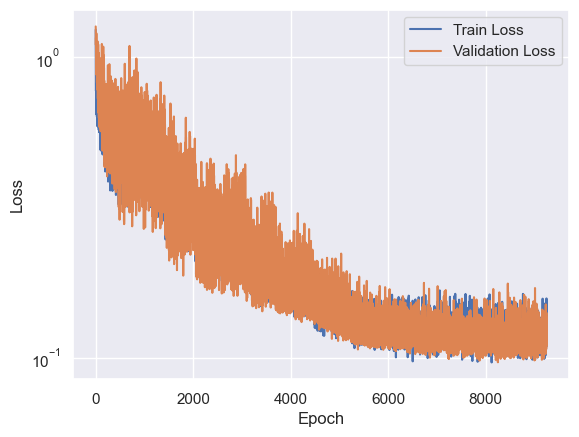

In [1374]:
# Plot losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [25]:
# Test the model
test_loss = test(model, test_loader, loss_fn, device=device)
print("Test loss: ", test_loss)

Test loss:  0.05588415265083313


## Check the model

In [76]:
def predict_and_plot_ttf(model, test_TTF_data, test_Vs_data, freq_data, device, plot_true=True, idx=None, print_output=False):
    
    # Use the model to predict the TTF
    model.eval()

    # Ensure idx is within bounds
    if idx is None:
        idx = np.random.randint(0, len(test_TTF_data))
    else:
        assert 0 <= idx < len(test_TTF_data), "Index out of bounds"

    # Use test_TTF_data and test_Vs_data
    test_TTF_check = test_TTF_data[idx]
    test_Vs_check = test_Vs_data[idx] * np.ones_like(freq_data)

    # Normalize
    test_TTF_check = normalize_data(test_TTF_check, mean_TTF, std_TTF)
    test_Vs_check = normalize_data(test_Vs_check, mean_Vs, std_Vs)
    freq_data = normalize_data(freq_data, mean_freq, std_freq)
    
    # Create dataset
    test_check_dataset = TTFDataset(test_TTF_check, test_Vs_check, freq_data)

    # Create dataloader
    test_check_loader = DataLoader(test_check_dataset, batch_size=1, shuffle=False)

    # Predict
    predictions = []
    targets = []
    Vs_target = []
    freq_target = []
    with torch.no_grad():
        for X, y in test_check_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predictions.append(y_pred.cpu().numpy())
            targets.append(y.cpu().numpy())
            Vs_target.append(X[:, 0].cpu().numpy())
            freq_target.append(X[:, -1].cpu().numpy())

    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    Vs_target = np.concatenate(Vs_target)
    freq_target = np.concatenate(freq_target)

    # Denormalize
    predictions = denormalize_data(predictions, mean_TTF, std_TTF)
    targets = denormalize_data(targets, mean_TTF, std_TTF)
    Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
    freq_target = denormalize_data(freq_target, mean_freq, std_freq)

    if print_output:
        print("Vs: ", Vs_target[0])
        #print("True TTF: ", targets)
        #print("Predicted TTF: ", predictions)

    # Plot
    if plot_true:
        plt.plot(freq_target, targets, label="True")
        plt.plot(freq_target, predictions, label="Predicted", linestyle="--")
        plt.legend()
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TTF")
        plt.title(f"Vs: {Vs_target[0]}")
        plt.show()

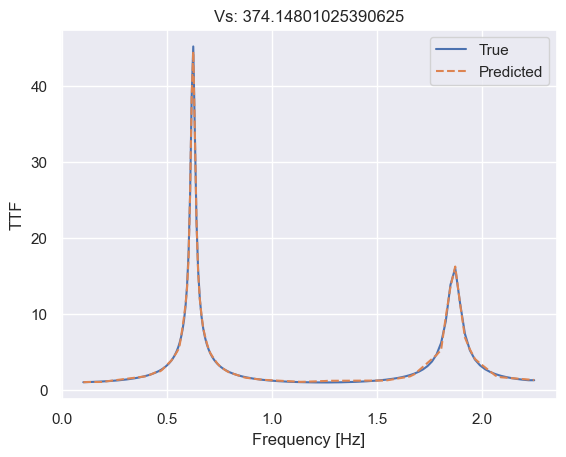

In [79]:
predict_and_plot_ttf(model, test_TTF_data, test_Vs_data, freq, device, plot_true=True, print_output=False)

In [28]:
# Predict and plot
model.eval()
predictions = []
target = []
Vs_target = []
freq_target = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        predictions.append(y_pred.cpu().numpy())
        target.append(y.cpu().numpy()) 
        Vs_target.append(X[:, 0].cpu().numpy())
        freq_target.append(X[:, -1].cpu().numpy())


predictions = np.concatenate(predictions)
target = np.concatenate(target)
Vs_target = np.concatenate(Vs_target)
freq_target = np.concatenate(freq_target)

# Order frequency
order = np.argsort(freq_target)
freq_target = freq_target[order]
Vs_target = Vs_target[order]
predictions = predictions[order]
target = target[order]


# Denormalize
Vs_target = denormalize_data(Vs_target, mean_Vs, std_Vs)
predictions = denormalize_data(predictions, mean_TTF, std_TTF)
target = denormalize_data(target, mean_TTF, std_TTF)
freq_target = denormalize_data(freq_target, mean_freq, std_freq)

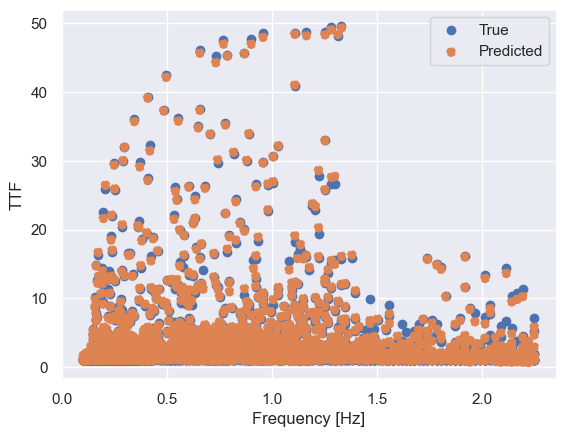

In [29]:
plt.scatter(freq_target, target, label="True")
plt.scatter(freq_target, predictions, label="Predicted", linestyle="--")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF")
plt.show()


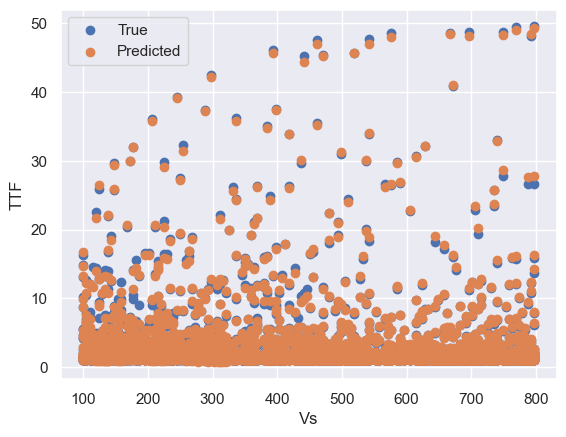

In [30]:
plt.scatter(Vs_target,target, label="True")
plt.scatter(Vs_target,predictions, label="Predicted")
plt.xlabel("Vs")
plt.ylabel("TTF")
plt.legend()
plt.show()


In [31]:
# Save the model
#torch.save(model.state_dict(), "MLP_TF_model.pth")

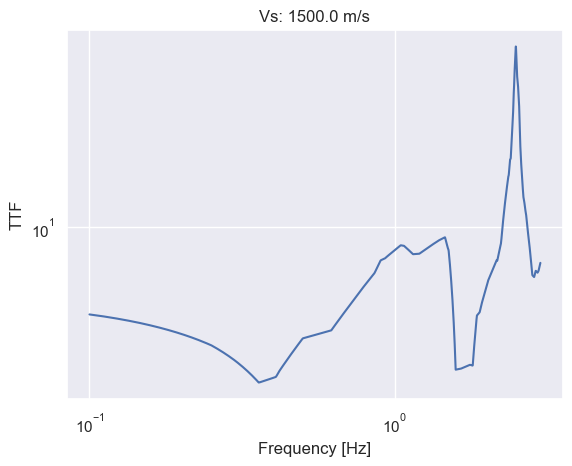

In [71]:
# Let's check with Vs = 1200 m/s

# Predict and plot
model.eval()
predictions = []

freq_2 = np.linspace(0.1, 3, 1000)
Vs_2 = 1500 * np.ones_like(freq_2)

with torch.no_grad():
    for i in range(len(freq_2)):
        Vs = Vs_2[i] * np.ones(30)
        freq = freq_2[i] * np.ones(1)
        # Normalize
        Vs = normalize_data(Vs, mean_Vs, std_Vs)
        freq = normalize_data(freq, mean_freq, std_freq)

        # Create input data
        input_data = np.concatenate((Vs, freq))
        input_data = torch.tensor(input_data, dtype=torch.float32).to(device).unsqueeze(0)

        # Predict
        y_pred = model(input_data)
        predictions.append(y_pred.cpu().numpy())

predictions = np.concatenate(predictions)

# Denormalize
predictions = denormalize_data(predictions, mean_TTF, std_TTF)

plt.loglog(freq_2, predictions)
plt.xlabel("Frequency [Hz]")
plt.ylabel("TTF")
plt.title("Vs: {} m/s".format(Vs_2[0]))
plt.show()

